In [555]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
import scipy
from sklearn import linear_model, feature_selection, metrics
from sklearn.metrics import roc_curve
from collections import Counter

In [556]:
df = pd.read_csv('transoformed_data.csv')
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,severity_of_disease,number_of_changes
0,0,0,5,5,18,1,1,pediatrics,41,0,...,-20,-20,-20,-20,-1,-1,0,1.000000,0.000009,0
1,0,0,15,1,1,7,3,missing,59,0,...,-20,-20,-20,-20,1,1,0,1.000000,0.000018,1
2,1,0,25,1,1,7,2,missing,11,5,...,-20,-20,-20,-20,-1,1,0,0.333333,0.000007,0
3,0,1,35,1,1,7,2,missing,44,1,...,-20,-20,-20,-20,1,1,0,1.000000,0.000014,1
4,0,1,45,1,1,7,1,missing,51,0,...,-20,-20,-20,-20,1,1,0,1.000000,0.000013,0


In [557]:
df.shape

(70431, 45)

In [558]:
# Selecting only numerical columns for normalization
df_norm = df.select_dtypes(include=[np.number])

epsilon = 1e-8  # Small positive constant to avoid division by zero

# Normalizing the numerical columns using min-max scaling
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min() + epsilon)

# Generating descriptive statistics for the normalized numerical columns
df_norm.describe()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,health_index,severity_of_disease,number_of_changes
count,70431.000000,70431.000000,70431.000000,70431.000000,70431.000000,70431.000000,70431.000000,70431.000000,70431.000000,70431.000000,...,70431.000000,70431.0,70431.000000,70431.000000,70431.000000,70431.000000,70431.00000,70431.000000,70431.000000,70431.000000
mean,0.134926,0.468018,0.672408,0.211082,0.062243,0.398813,0.252591,0.319977,0.237010,0.183334,...,0.000099,0.0,0.000028,0.000014,0.449546,0.761114,0.08935,0.919881,0.360976,0.065475
std,0.267715,0.498980,0.177524,0.342636,0.215092,0.292667,0.226131,0.151927,0.292482,0.103535,...,0.009969,0.0,0.005329,0.003768,0.497451,0.426406,0.28525,0.218297,0.138212,0.118960
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.555556,0.000000,0.000000,0.000000,0.076923,0.229008,0.000000,0.112500,...,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.272654,0.000000
50%,0.000000,0.000000,0.666667,0.000000,0.000000,0.600000,0.153846,0.328244,0.166667,0.162500,...,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.358192,0.000000
75%,0.000000,1.000000,0.777778,0.500000,0.000000,0.600000,0.384615,0.427481,0.333333,0.237500,...,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.00000,1.000000,0.449077,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.999731,1.000000


In [559]:
numercial_features = list(df.select_dtypes(include=[np.number]))
numercial_features.remove('readmitted')

In [560]:
# Creating a logistic regression classifier
clf = linear_model.LogisticRegression()

# Defining the feature columns and target variable
X = df[numercial_features]
Y = df['readmitted']

# Fitting the logistic regression model
clf.fit(X, Y)

# Printing model evaluation metrics and coefficients
print("Model score:\n {}".format(clf.score(X,Y)))
print("Intercept:\n {}".format(clf.intercept_))
print("Coefficients:\n")
for feat, coef in zip(f_cols, clf.coef_[0]):
    print(" {:>20}: {}".format(feat, coef))

Model score:
 0.9105223552129034
Intercept:
 [-0.00160305]
Coefficients:

                 race: -0.011402885141148157
               gender: 0.004989263974960034
                  age: 0.008379275841164314
    admission_type_id: 0.000556907072663735
 discharge_disposition_id: 0.0115864930903646
  admission_source_id: -0.003938772137051016
     time_in_hospital: 0.035097652676997174
   num_lab_procedures: 0.0011702168452916684
       num_procedures: -0.019201267375754807
      num_medications: 0.0044585626022161755
    number_outpatient: -0.004781403142245233
     number_emergency: 0.07673269428636338
     number_inpatient: 0.33467404353093816
     number_diagnoses: 0.03440047767284146
            metformin: -0.005788156996311913
          repaglinide: 0.011726553764314224
          nateglinide: -0.012387256387470307
       chlorpropamide: -0.01241415573679518
          glimepiride: -0.005864905263430852
        acetohexamide: 0.030058002528123663
            glipizide: 0.0004376535858

In [561]:
# Creating a logistic regression classifier
clf = linear_model.LogisticRegression()

# Defining the feature columns and target variable
f_cols = df_norm.drop(['readmitted'], axis=1)
X = df_norm.loc[:, df_norm.columns != 'readmitted']
Y = df['readmitted']

# Fitting the logistic regression model
clf.fit(X, Y)

# Printing model evaluation metrics and coefficients
print("Model score:\n {}".format(clf.score(X,Y)))
print("Intercept:\n {}".format(clf.intercept_))
print("Coefficients:\n")
for feat, coef in zip(f_cols, clf.coef_[0]):
    print(" {:>20}: {}".format(feat, coef))

Model score:
 0.9105507517996336
Intercept:
 [-3.2031308]
Coefficients:

                 race: -0.01794432918571031
               gender: 0.011446664892106724
                  age: 0.7443512057557093
    admission_type_id: -0.009462978708440005
 discharge_disposition_id: 0.1813752243791185
  admission_source_id: -0.02484303682064428
     time_in_hospital: 0.462639793707475
   num_lab_procedures: -0.005294907766642752
       num_procedures: -0.1171406298216643
      num_medications: 0.230038937453638
    number_outpatient: -1.1036308147192555
     number_emergency: 0.11022168035410343
     number_inpatient: 3.4232541016812115
     number_diagnoses: 0.5555471349554452
            metformin: -0.1785784372406157
          repaglinide: 0.34874568877674594
          nateglinide: -0.3469433246103916
       chlorpropamide: -0.23733063047243272
          glimepiride: -0.15699203344303778
        acetohexamide: -0.012998492583711684
            glipizide: 0.004953075346179497
            glyb

In [562]:
# We have built up an initial model wherein we have used all the dataset. The model has a good score 
# (prediction accuracy) of about 80%. The equation of the model is
# 
# log(p/(1−p)) = −0.0017 − 0.0049 ∗ age −3.7528 ∗ fnlwgt + 0.0003 ∗ capitalgain + 
# 0.0007 ∗ capitalloss − 0.0104 ∗ hoursperweek

In [563]:
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X0, Y, test_size=0.2)

# Creating and fitting the logistic regression model
clf = linear_model.LogisticRegression()
clf.fit(X_train, Y_train)

# Printing model scores against training and test data
print("Score against training data: {}".format(clf.score(X_train, Y_train)))
print("Score against test data: {}".format(clf.score(X_test, Y_test)))

Score against training data: 1.0
Score against test data: 1.0


In [564]:
# Splitting the data into a training and a test sets seems to give us similar scores. 
# Trying to improve the model may come from integrating some of the categorical variables. For that purpose, 
# we will convert those categorical variables into numeric by using indicator (or dummy) variables. 
# These are variables that have value 0 or 1. Below is the process of getting dummy variables:

In [565]:
# Selecting categorical columns
df_cat_cols = df.select_dtypes(include=['object'])
df_cat_cols.head()

,medical_specialty,diag_1,diag_2,diag_3
0,pediatrics,diabetes,diabetes,diabetes
1,missing,other,diabetes,other
2,missing,pregnecy,diabetes,other
3,missing,other,diabetes,circulatory
4,missing,neoplasms,neoplasms,diabetes


In [566]:
le = LabelEncoder()
for col in df_cat_cols:
    df[col] = le.fit_transform(df[col])

In [567]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
race,70431.0,0.269853,0.535429,0.000000e+00,0.000000,0.000000,0.000000,2.000000
gender,70431.0,0.468018,0.498980,0.000000e+00,0.000000,0.000000,1.000000,1.000000
age,70431.0,65.516676,15.977185,5.000000e+00,55.000000,65.000000,75.000000,95.000000
admission_type_id,70431.0,1.844330,1.370545,1.000000e+00,1.000000,1.000000,3.000000,5.000000
discharge_disposition_id,70431.0,2.058128,3.656561,1.000000e+00,1.000000,1.000000,1.000000,18.000000
admission_source_id,70431.0,4.988130,2.926673,1.000000e+00,1.000000,7.000000,7.000000,11.000000
time_in_hospital,70431.0,4.283682,2.939699,1.000000e+00,2.000000,3.000000,6.000000,14.000000
medical_specialty,70431.0,1.547614,1.736881,0.000000e+00,0.000000,2.000000,2.000000,7.000000
num_lab_procedures,70431.0,42.917011,19.902483,1.000000e+00,31.000000,44.000000,57.000000,132.000000
num_procedures,70431.0,1.422058,1.754894,0.000000e+00,0.000000,1.000000,2.000000,6.000000


In [568]:
# We may use the RFE feature selection from sklearn. Below is an example of its usage.
len(df.columns)

45

In [569]:
# Create a logistic regression model
model = linear_model.LogisticRegression()

# Define the feature matrix X0 and the target variable Y0
X0 = df.loc[:, df.columns != 'readmitted']
Y0 = df['readmitted']

# Initialize the RFE selector with a logistic regression model and select 15 features with a step of 2
selector = feature_selection.RFE(model, n_features_to_select=25, step=2)

# Fit the selector to the data
selector = selector.fit(X0, Y0)

# Get the selected features based on the support_ attribute of the selector
selected_features = X0.loc[:, selector.support_]

# Print the selected features
print("Selected features:\n{}".format(',\n'.join(list(selected_features))))

Selected features:
race,
age,
discharge_disposition_id,
time_in_hospital,
medical_specialty,
num_procedures,
number_outpatient,
number_emergency,
number_inpatient,
diag_1,
number_diagnoses,
repaglinide,
nateglinide,
chlorpropamide,
acetohexamide,
tolbutamide,
troglitazone,
tolazamide,
glimepiride-pioglitazone,
metformin-rosiglitazone,
metformin-pioglitazone,
change,
diabetesMed,
health_index,
number_of_changes


## Evaluate the Regression Model

In [570]:
# Assigning selected features to X
X = selected_features

standardizer = StandardScaler()
X0 = standardizer.fit_transform(X)
X0 = pd.DataFrame(X0, index=X.index, columns=X.columns)
Y0 = df['readmitted']

# Splitting the data into training and testing sets
trainX, testX, trainY, testY = train_test_split(X0, Y0, test_size=0.3, random_state=0)

# Creating a logistic regression classifier
clf = linear_model.LogisticRegression()

# Fitting the classifier to the training data
clf.fit(trainX, trainY)

# Predicting the target variable for the test set
predicted = clf.predict(testX)

# Calculating the mean hits (proportion of correctly predicted instances)
mean_hits = np.mean(predicted == testY)

# Calculating the accuracy score
accuracy_score = metrics.accuracy_score(testY, predicted)

# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), X0, Y0, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Mean hits: 0.9115002366303834
Accuracy score: 0.9115002366303834
Cross-validation mean scores: 0.9104371677090588


In [571]:
"""
# We see that we did not improve the model score but let us carry on and look at another metric for evaluating a 
classifcation model. This time, we are going to generate confusion matrices and then plot the ROC curve. We can then get 
the AUC (Area Under the Curve).
"""

'\n# We see that we did not improve the model score but let us carry on and look at another metric for evaluating a \nclassifcation model. This time, we are going to generate confusion matrices and then plot the ROC curve. We can then get \nthe AUC (Area Under the Curve).\n'

In [572]:
def classify_for_threshold(clf, testX, testY, t):
    # Predicting probabilities for the positive class
    prob_data = pd.DataFrame(clf.predict_proba(testX)[:, 1])
    
    # Classifying based on the specified threshold
    prob_data['predict'] = np.where(prob_data[0] >= t, 1, 0)
    
    # Adding the actual labels
    prob_data['actual'] = testY
    
    # Creating a cross-tabulation of predicted vs. actual labels
    return pd.crosstab(prob_data['actual'], prob_data['predict'])

# Specified thresholds
thresholds = [0.05, 0.10, 0.20]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(clf, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.05: 
predict    0     1
actual            
0.0      237  5348
1.0       30   596

Confusion Matrix for Threshold 0.1: 
predict     0     1
actual             
0.0      4092  1493
1.0       441   185

Confusion Matrix for Threshold 0.2: 
predict     0   1
actual           
0.0      5508  77
1.0       612  14


In [573]:
"""
From these confusion matrices, you can observe the trade-off between false positives and false negatives as the 
threshold value changes. A lower threshold (e.g., 0.05) tends to classify more instances as positive, resulting in a 
higher number of false positives but fewer false negatives. Conversely, a higher threshold (e.g., 0.2) tends to classify 
more instances as negative, resulting in a lower number of false positives but a higher number of false negatives.

Threshold 0.1:

FP: 1484 (moderate)
FN: 444 (moderate)
This threshold provides a more balanced trade-off between false positives and false negatives, 
with both values being moderate.
"""

'\nFrom these confusion matrices, you can observe the trade-off between false positives and false negatives as the \nthreshold value changes. A lower threshold (e.g., 0.05) tends to classify more instances as positive, resulting in a \nhigher number of false positives but fewer false negatives. Conversely, a higher threshold (e.g., 0.2) tends to classify \nmore instances as negative, resulting in a lower number of false positives but a higher number of false negatives.\n\nThreshold 0.1:\n\nFP: 1484 (moderate)\nFN: 444 (moderate)\nThis threshold provides a more balanced trade-off between false positives and false negatives, \nwith both values being moderate.\n'

AUC = 0.5984867504067615


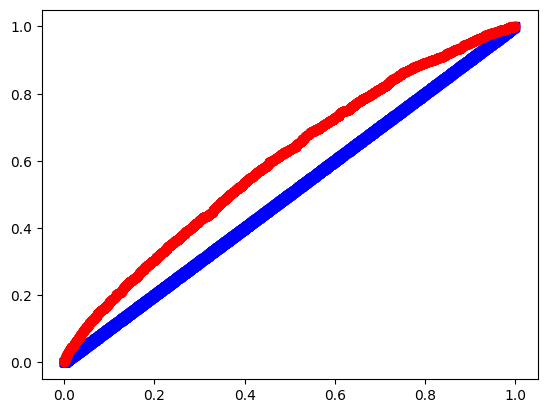

In [574]:
# Predicting probabilities for the positive class
prob = np.array(clf.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()

[[0.91732428 0.08267572]
 [0.91189074 0.08810926]
 [0.96433288 0.03566712]
 ...
 [0.9445388  0.0554612 ]
 [0.9456955  0.0543045 ]
 [0.9327489  0.0672511 ]]


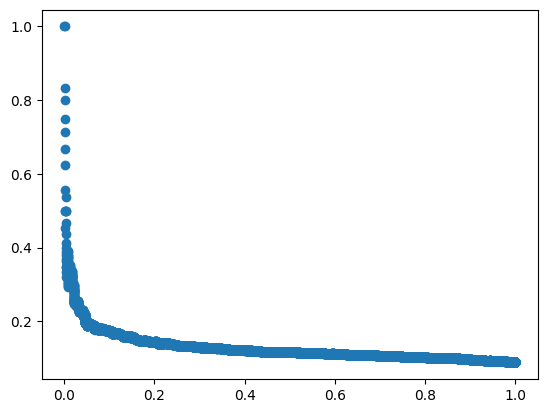

In [575]:
pred_score = clf.predict_proba(testX)
print(pred_score)

testY = testY - 1  # Assuming testY has values 1 and 2

p,r,t = precision_recall_curve(y_true=testY, probas_pred=pred_score[:,1])
plt.figure()
plt.scatter(r,p)
plt.show()

### LogisticRegression UnderSampler

In [576]:
# Assigning selected features to X
X = selected_features

standardizer = StandardScaler()
X0 = standardizer.fit_transform(X)
X0 = pd.DataFrame(X0, index=X.index, columns=X.columns)
Y0 = df['readmitted']

# Create an undersampler object
undersampler = RandomUnderSampler(random_state=42)

# Undersample the data
X_undersampled, y_undersampled = undersampler.fit_resample(X0, Y0)

# Check the new class distribution
print("Original dataset shape:", Counter(y))
print("Undersampled dataset shape:", Counter(y_undersampled))

# Split the undersampled data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_undersampled, y_undersampled, test_size=0.3, random_state=0)


# Creating a logistic regression classifier
clf_under = linear_model.LogisticRegression()

# Fitting the classifier to the training data
clf_under.fit(trainX, trainY)

# Predicting the target variable for the test set
predicted = clf_under.predict(testX)

# Calculating the mean hits (proportion of correctly predicted instances)
mean_hits = np.mean(predicted == testY)

# Calculating the accuracy score
accuracy_score = metrics.accuracy_score(testY, predicted)

# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), X_undersampled, y_undersampled, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Original dataset shape: Counter({0: 64138, 1: 6293})
Undersampled dataset shape: Counter({0: 6293, 1: 6293})
Mean hits: 0.5707097457627118
Accuracy score: 0.5707097457627118
Cross-validation mean scores: 0.5576057157938203


In [577]:
# Specified thresholds
thresholds = [0.4, 0.5, 0.6]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(clf_under, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.4: 
predict   0   1
actual         
0.0      20  80
1.0       8  94

Confusion Matrix for Threshold 0.5: 
predict   0   1
actual         
0.0      63  37
1.0      54  48

Confusion Matrix for Threshold 0.6: 
predict   0  1
actual        
0.0      95  5
1.0      93  9


AUC = 0.6060575528140009


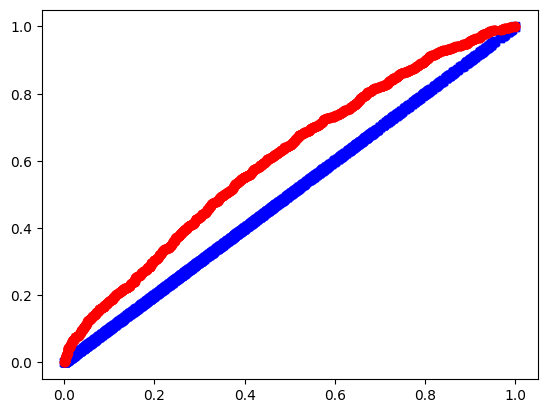

In [578]:
# Predicting probabilities for the positive class
prob = np.array(clf_under.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()

In [579]:
pred_score = clf.predict_proba(testX)
print(pred_score)

[[0.93119227 0.06880773]
 [0.89693006 0.10306994]
 [0.92510562 0.07489438]
 ...
 [0.93173107 0.06826893]
 [0.92641242 0.07358758]
 [0.89904795 0.10095205]]


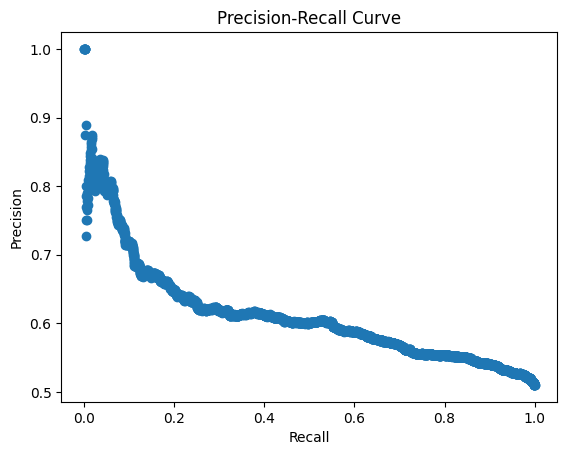

In [580]:
testY = testY - 1  # testY has values 1 and 2

p, r, t = precision_recall_curve(y_true=testY, probas_pred=pred_score[:, 1])

plt.figure()
plt.scatter(r, p)

# Add labels to the x-axis and y-axis
plt.xlabel('Recall')
plt.ylabel('Precision')

# Add a title to the plot (optional)
plt.title('Precision-Recall Curve')

plt.show()

## LogisticRegression OverSampler

In [581]:
# Assigning selected features to X
X = selected_features

standardizer = StandardScaler()
X0 = standardizer.fit_transform(X)
X0 = pd.DataFrame(X0, index=X.index, columns=X.columns)
Y0 = df['readmitted']

# Create an undersampler object
oversampler = RandomOverSampler(random_state=42)

# Undersample the data
X_over, y_over = oversampler.fit_resample(X0, Y0)

# Check the new class distribution
print("Original dataset shape:", Counter(y))
print("Undersampled dataset shape:", Counter(y_over))

# Split the undersampled data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_over, y_over, test_size=0.3, random_state=0)


# Creating a logistic regression classifier
clf_over = linear_model.LogisticRegression()

# Fitting the classifier to the training data
clf_over.fit(trainX, trainY)

# Predicting the target variable for the test set
predicted = clf_over.predict(testX)

# Calculating the mean hits (proportion of correctly predicted instances)
mean_hits = np.mean(predicted == testY)

# Calculating the accuracy score
accuracy_score = metrics.accuracy_score(testY, predicted)

# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), X_over, y_over, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Original dataset shape: Counter({0: 64138, 1: 6293})
Undersampled dataset shape: Counter({0: 64138, 1: 64138})
Mean hits: 0.5734480160070681
Accuracy score: 0.5734480160070681
Cross-validation mean scores: 0.5538603636812345


In [582]:
# Specified thresholds
thresholds = [0.4, 0.5, 0.6]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(clf_over, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.4: 
predict     0     1
actual             
0.0      1438  8865
1.0       134  1019

Confusion Matrix for Threshold 0.5: 
predict     0     1
actual             
0.0      5704  4599
1.0       656   497

Confusion Matrix for Threshold 0.6: 
predict     0     1
actual             
0.0      8936  1367
1.0      1005   148


AUC = 0.6071664017077856


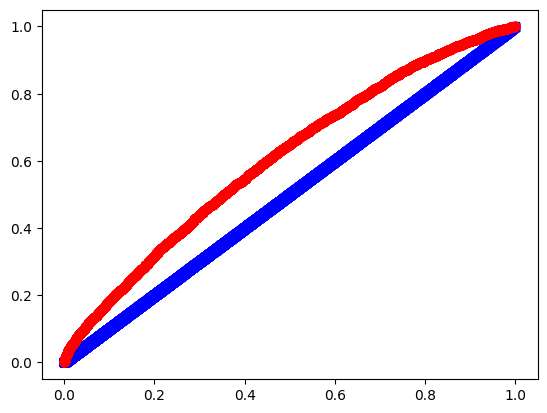

In [583]:
# Predicting probabilities for the positive class
prob = np.array(clf_over.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()

[[0.54350256 0.45649744]
 [0.40885028 0.59114972]
 [0.57326027 0.42673973]
 ...
 [0.45579507 0.54420493]
 [0.50226554 0.49773446]
 [0.4460564  0.5539436 ]]


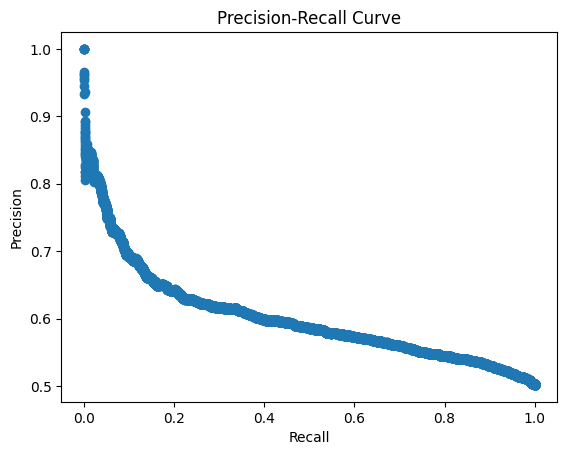

In [584]:
pred_score = clf_over.predict_proba(testX)
print(pred_score)

testY = testY - 1  # testY has values 1 and 2

p, r, t = precision_recall_curve(y_true=testY, probas_pred=pred_score[:, 1])

plt.figure()
plt.scatter(r, p)

# Add labels to the x-axis and y-axis
plt.xlabel('Recall')
plt.ylabel('Precision')

# Add a title to the plot (optional)
plt.title('Precision-Recall Curve')

plt.show()

## RandomForestClassifier

In [585]:
# Assigning selected features to X
X = selected_features

standardizer = StandardScaler()
X0 = standardizer.fit_transform(X)
X0 = pd.DataFrame(X0, index=X.index, columns=X.columns)
Y0 = df['readmitted']

# Split the undersampled data into train and test sets
trainX, testX, trainY, testY = train_test_split(X0, Y0, test_size=0.3, random_state=0)


#Builds up a Random Forest classifier
crf = RandomForestClassifier(n_jobs=-1, n_estimators=400, min_samples_leaf=5, \
                             max_depth = 30, oob_score=True)
crf.fit(trainX,trainY)

# Predicting the target variable for the test set
predicted = crf.predict(testX)

# Calculating the mean hits (proportion of correctly predicted instances)
mean_hits = np.mean(predicted == testY)

# Calculating the accuracy score
accuracy_score = metrics.accuracy_score(testY, predicted)

# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), X0, Y0, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Mean hits: 0.9115002366303834
Accuracy score: 0.9115002366303834
Cross-validation mean scores: 0.9104371677090588


In [586]:
# Specified thresholds
thresholds = [0.05, 0.10, 0.20]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(crf, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.05: 
predict     0     1
actual             
0.0      1270  4315
1.0       135   491

Confusion Matrix for Threshold 0.1: 
predict     0     1
actual             
0.0      3725  1860
1.0       412   214

Confusion Matrix for Threshold 0.2: 
predict     0    1
actual            
0.0      5366  219
1.0       598   28


AUC = 0.6179410515268129


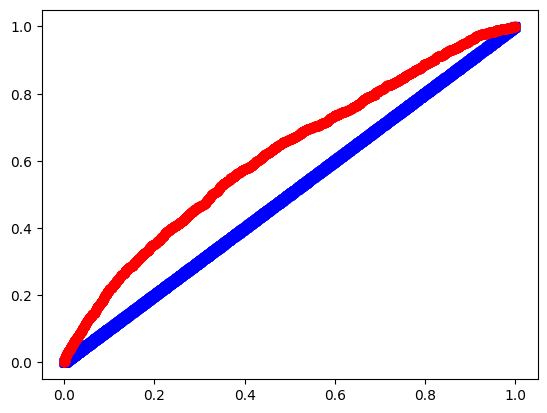

In [587]:
# Predicting probabilities for the positive class
prob = np.array(crf.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()

[[0.91541991 0.08458009]
 [0.89533986 0.10466014]
 [0.97277359 0.02722641]
 ...
 [0.93276297 0.06723703]
 [0.9641632  0.0358368 ]
 [0.96912769 0.03087231]]


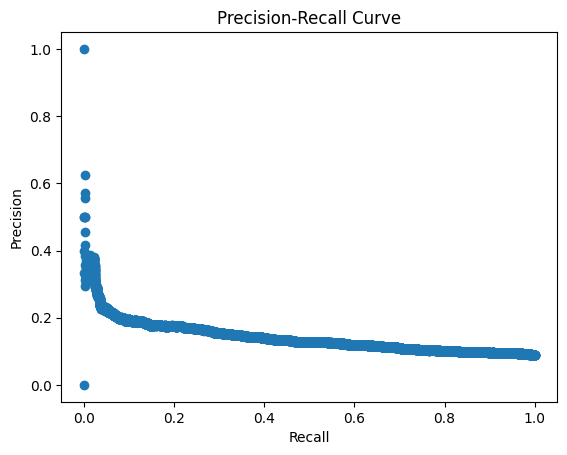

In [588]:
pred_score = crf.predict_proba(testX)
print(pred_score)

testY = testY - 1  # testY has values 1 and 2

p, r, t = precision_recall_curve(y_true=testY, probas_pred=pred_score[:, 1])

plt.figure()
plt.scatter(r, p)

# Add labels to the x-axis and y-axis
plt.xlabel('Recall')
plt.ylabel('Precision')

# Add a title to the plot (optional)
plt.title('Precision-Recall Curve')

plt.show()

In [589]:
# crossvalidation = KFold(10, shuffle=True)
# score1=cross_val_score(clf, X0, Y0,scoring='accuracy',cv=crossvalidation,n_jobs=-1)
# print("X valiation score for Logistic regression is: {:5.4f}".format(np.mean(score1)))
# score2=cross_val_score(crf, X0, Y0,scoring='accuracy',cv=crossvalidation,n_jobs=-1)
# print("X validation score for Random Forest: {:5.4f}".format(np.mean(score2)))

In [626]:
# Assigning selected features to X
X = selected_features

standardizer = StandardScaler()
X0 = standardizer.fit_transform(X)
X0 = pd.DataFrame(X0, index=X.index, columns=X.columns)
Y0 = df['readmitted']

# Create an undersampler object
oversampler = RandomOverSampler(random_state=42)

# Undersample the data
X_over, y_over = oversampler.fit_resample(X0, Y0)

# Check the new class distribution
print("Original dataset shape:", Counter(y))
print("Undersampled dataset shape:", Counter(y_over))

# Split the undersampled data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_over, y_over, test_size=0.3, random_state=0)


#Builds up a Random Forest classifier
crf_over = RandomForestClassifier(n_jobs=-1, n_estimators=400, min_samples_leaf=5, \
                             max_depth = 30, oob_score=True)
crf_over.fit(trainX,trainY)

# Predicting the target variable for the test set
predicted = crf_over.predict(testX)

# Calculating the mean hits (proportion of correctly predicted instances)
mean_hits = np.mean(predicted == testY)

# Calculating the accuracy score
accuracy_score = metrics.accuracy_score(testY, predicted)

# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), trainX, trainY, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Original dataset shape: Counter({0: 64138, 1: 6293})
Undersampled dataset shape: Counter({0: 64138, 1: 64138})
Mean hits: 0.8548190109918665
Accuracy score: 0.8548190109918665
Cross-validation mean scores: 0.574944417449178


In [608]:
# Specified thresholds
thresholds = [0.4, 0.5, 0.6]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(crf_over, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.4: 
predict     0     1
actual             
0.0      3426  6877
1.0       356   797

Confusion Matrix for Threshold 0.5: 
predict     0     1
actual             
0.0      4989  5314
1.0       549   604

Confusion Matrix for Threshold 0.6: 
predict     0     1
actual             
0.0      6592  3711
1.0       729   424


AUC = 0.933893125144626


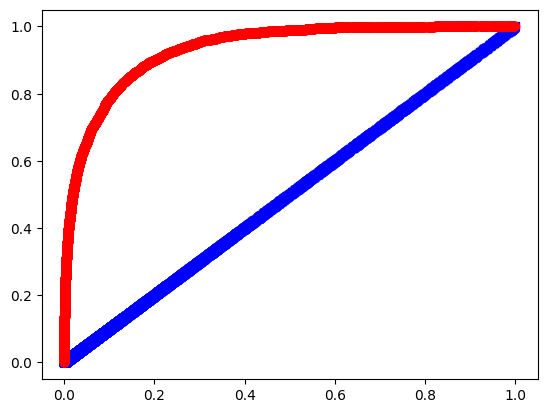

In [609]:
# Predicting probabilities for the positive class
prob = np.array(crf_over.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()

[[0.4854571  0.5145429 ]
 [0.24226147 0.75773853]
 [0.41576816 0.58423184]
 ...
 [0.59204927 0.40795073]
 [0.36659567 0.63340433]
 [0.39996408 0.60003592]]


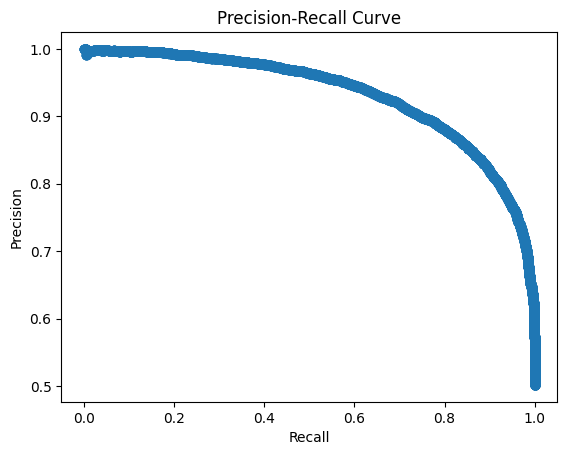

In [610]:
pred_score = crf_over.predict_proba(testX)
print(pred_score)

testY = testY - 1  # testY has values 1 and 2

p, r, t = precision_recall_curve(y_true=testY, probas_pred=pred_score[:, 1])

plt.figure()
plt.scatter(r, p)

# Add labels to the x-axis and y-axis
plt.xlabel('Recall')
plt.ylabel('Precision')

# Add a title to the plot (optional)
plt.title('Precision-Recall Curve')

plt.show()

In [510]:
# Assigning selected features to X
X = selected_features

standardizer = StandardScaler()
X0 = standardizer.fit_transform(X)
X0 = pd.DataFrame(X0, index=X.index, columns=X.columns)
Y0 = df['readmitted']

# Create an undersampler object
undersampler = RandomUnderSampler(random_state=42)

# Undersample the data
X_under, y_under = undersampler.fit_resample(X0, Y0)

# Check the new class distribution
print("Original dataset shape:", Counter(y))
print("Undersampled dataset shape:", Counter(y_over))

# Split the undersampled data into train and test sets
trainX, testX, trainY, testY = train_test_split(X_under, y_under, test_size=0.3, random_state=0)


#Builds up a Random Forest classifier
crf_under = RandomForestClassifier(n_jobs=-1, n_estimators=400, min_samples_leaf=5, \
                             max_depth = 30, oob_score=True)
crf_under.fit(trainX,trainY)

# Predicting the target variable for the test set
predicted = crf_under.predict(testX)

# Calculating the mean hits (proportion of correctly predicted instances)
mean_hits = np.mean(predicted == testY)

# Calculating the accuracy score
accuracy_score = metrics.accuracy_score(testY, predicted)

# Performing 10-fold cross-validation and computing the mean scores
scores = cross_val_score(linear_model.LogisticRegression(), X_under, y_under, scoring='accuracy', cv=10)
cross_val_mean_scores = scores.mean()

# Printing the mean hits, accuracy score, and cross-validation mean scores
print("Mean hits: {}".format(mean_hits))
print("Accuracy score: {}".format(accuracy_score))
print("Cross-validation mean scores: {}".format(cross_val_mean_scores))

Original dataset shape: Counter({0: 64138, 1: 6293})
Undersampled dataset shape: Counter({0: 64138, 1: 64138})
Mean hits: 0.5979872881355932
Accuracy score: 0.5979872881355932
Cross-validation mean scores: 0.5576057157938203


In [511]:
# Specified thresholds
thresholds = [0.3, 0.4, 0.5]
for threshold in thresholds:
    confusion_matrix = classify_for_threshold(crf_under, testX, testY, threshold)
    print("\nConfusion Matrix for Threshold {}: \n{}".format(threshold, confusion_matrix))


Confusion Matrix for Threshold 0.3: 
predict  0    1
actual         
0.0      6   94
1.0      2  100

Confusion Matrix for Threshold 0.4: 
predict   0   1
actual         
0.0      29  71
1.0      21  81

Confusion Matrix for Threshold 0.5: 
predict   0   1
actual         
0.0      61  39
1.0      52  50


AUC = 0.6351407217971929


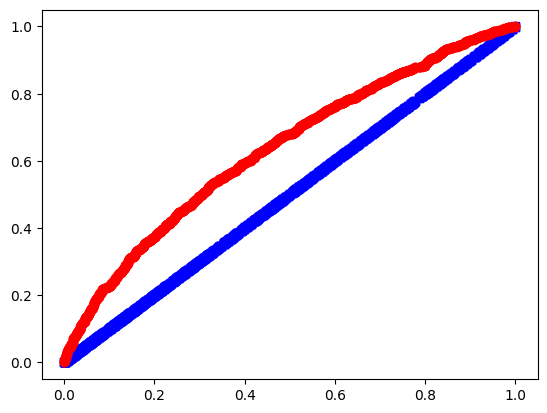

In [512]:
# Predicting probabilities for the positive class
prob = np.array(crf_under.predict_proba(testX)[:, 1])

# Incrementing testY by 1 to convert the labels to 1 and 2
testY += 1

# Calculating the false positive rate and sensitivity (true positive rate) for ROC curve
fpr, sensitivity, _ = metrics.roc_curve(testY, prob, pos_label=2)

# Computing the Area Under Curve (AUC) for the ROC curve
print("AUC = {}".format(metrics.auc(fpr, sensitivity)))

# Plotting the ROC curve
plt.scatter(fpr, fpr, c='b', marker='s')  # Plotting the line y = x (diagonal)
plt.scatter(fpr, sensitivity, c='r', marker='o')  # Plotting the ROC curve
plt.show()

[[0.30864018 0.69135982]
 [0.33835012 0.66164988]
 [0.63294742 0.36705258]
 ...
 [0.46314311 0.53685689]
 [0.66011216 0.33988784]
 [0.58943302 0.41056698]]


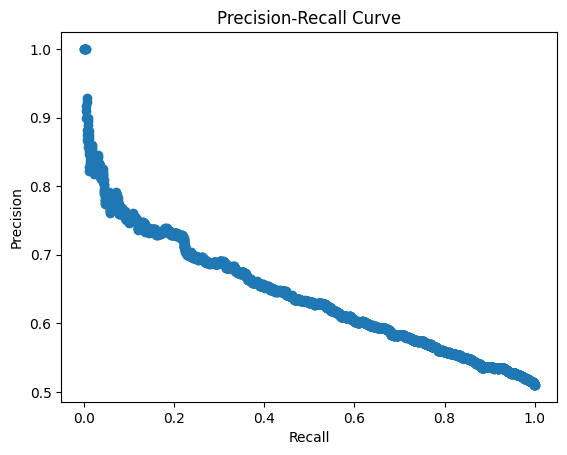

In [513]:
pred_score = crf_under.predict_proba(testX)
print(pred_score)

testY = testY - 1  # testY has values 1 and 2

p, r, t = precision_recall_curve(y_true=testY, probas_pred=pred_score[:, 1])

plt.figure()
plt.scatter(r, p)

# Add labels to the x-axis and y-axis
plt.xlabel('Recall')
plt.ylabel('Precision')

# Add a title to the plot (optional)
plt.title('Precision-Recall Curve')

plt.show()

## K means

In [514]:
len(testX)

3776

Text(0.5, 1.0, 'Elbow Method for Optimal Number of Clusters')

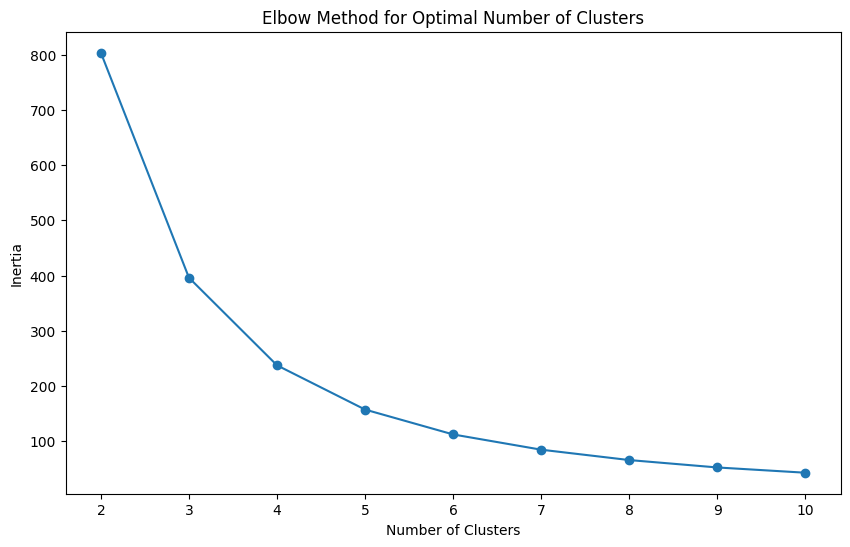

In [627]:
# Implement K-means clustering on the predictions
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Get the predicted probabilities
predictions = crf_over.predict_proba(testX)

# Implement the elbow method to find the optimal number of clusters
inertias = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(predictions)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')

Optimal number of clusters: 4


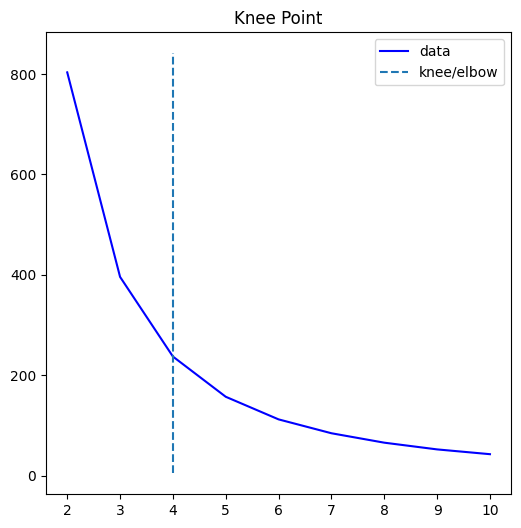

In [628]:
# Use KneeLocator to find the optimal number of clusters
kl = KneeLocator(range(2, 11), inertias, curve='convex', direction='decreasing')
optimal_k = kl.knee

# Visualize the KneeLocator's identified "knee" point
kl.plot_knee()

# Print the optimal number of clusters
print(f"Optimal number of clusters: {optimal_k}")

In [629]:
len(predictions)

38483

In [630]:
# Create the K-means clusterer
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the K-means model to the predictions
clusters = kmeans.fit_predict(predictions)

# Print the cluster assignments
print("Cluster assignments:", clusters)

Cluster assignments: [0 2 0 ... 3 0 0]


In [634]:
len(testY)

38483

In [631]:
# Fit the K-means model to the entire dataset instead of just the test set predictions
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# clusters = kmeans.fit_predict(X_over)

# Now you can compare clusters with the target variable distribution
print("Cluster distribution:")
for cluster in range(optimal_k):
    cluster_samples = test[clusters == cluster]
    cluster_targets = y_over[clusters == cluster]
    print(f"Cluster {cluster}:")
    print(Counter(cluster_targets))

Cluster distribution:


ValueError: Item wrong length 38483 instead of 128276.

In [615]:
# Build local classifiers based on clustering
local_classifiers = {}
for cluster in range(optimal_k):
    cluster_samples = X_over[clusters == cluster]
    cluster_targets = y_over[clusters == cluster]
    local_clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Using RandomForestClassifier
    local_clf.fit(cluster_samples, cluster_targets)
    local_classifiers[cluster] = local_clf

In [550]:
local_classifiers

{0: RandomForestClassifier(random_state=42),
 1: RandomForestClassifier(random_state=42),
 2: RandomForestClassifier(random_state=42),
 3: RandomForestClassifier(random_state=42)}

In [625]:
len(testX)/len(trainX)

0.42857461049302287

In [619]:
# Evaluate the local classifiers
for cluster, local_clf in local_classifiers.items():
    test_samples = X_over[clusters == cluster]
    test_targets = y_over[clusters == cluster]
    predictions = local_clf.predict(test_samples)
    acc = accuracy_score(test_targets, predictions)  # Renamed the variable to 'acc'
    print(f"Cluster {cluster} local classifier accuracy: {acc}")

TypeError: 'float' object is not callable

In [ ]:
# Based on the elbow curve, choose the optimal number of clusters
optimal_k = ...  # Set the optimal number of clusters here

# Create the K-means clusterer
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Fit the K-means model to the predictions
clusters = kmeans.fit_predict(predictions)

# Print the cluster assignments
print("Cluster assignments:", clusters)

In [ ]:
# Implement K-means clustering on the predictions
from sklearn.cluster import KMeans

# Get the predicted probabilities
predictions = crf_over.predict_proba(testX)

# Determine the number of clusters (k)
n_clusters = 3  

# Create the K-means clusterer
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the K-means model to the predictions
clusters = kmeans.fit_predict(predictions)

# Print the cluster assignments
print("Cluster assignments:", clusters)

In [28]:
#'number_emergency', 
numeric_features = ['age','time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
                    'health_index', 'severity_of_disease', 'number_of_changes', 
                    'metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide',\
            'glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol',\
            'troglitazone','tolazamide','insulin','glyburide-metformin','glipizide-metformin',\
            'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone', 'change', 'diabetesMed']

categorical_features = []
rejected_features = []

for col in df.columns :
    if col not in numeric_features :
        categorical_features.append(col)

In [15]:
for col in categorical_features : 
    data_crosstab = pd.crosstab(df['readmitted'],  
                                df[col], 
                                margins = False) 

    stat, p, dof, expected = scipy.stats.chi2_contingency(data_crosstab)
    if p < 0.4 :
	    print(p, col, 'is significant')
    else:
        print(p, col, 'is not significant')
        rejected_features.append(col)

#rejected_features.remove('admission_type_id')
print('\n\n', rejected_features)
df.drop(rejected_features, axis = 1, inplace = True)

0.011000300535663983 race is significant
0.5649365136977416 gender is not significant
0.018235268523518786 admission_type_id is significant
2.2858748125338644e-177 discharge_disposition_id is significant
0.08688102822592889 admission_source_id is significant
1.6017605412957235e-06 medical_specialty is significant
7.047139731365279e-16 diag_1 is significant
6.0033786077833e-08 diag_2 is significant
1.8929103548343518e-07 diag_3 is significant
0.0 readmitted is significant


 ['gender']


In [16]:
rejected_features = []
for col in numeric_features:
    rho , pval = scipy.stats.spearmanr(df['readmitted'], df[col])
    print(col, rho, pval)
    

print('\n\n')
for col in numeric_features :
    rho , pval = scipy.stats.spearmanr(df['readmitted'], df[col])
    if pval < 0.4 : 
        print(col, 'is significant')
    else : 
        print(col, 'is not significant')
        rejected_features.append(col)

print(rejected_features)
## lets remove rejected_features
df.drop(rejected_features, axis = 1, inplace=True)

age 0.04699517679216786 9.763088866595248e-36
time_in_hospital 0.05865854050984207 9.88788178411997e-55
num_lab_procedures 0.03205313657980457 1.7609829498436774e-17
num_procedures 0.0037141294409280727 0.32429372315318505
num_medications 0.042222285096625414 3.6376441367407055e-29
number_outpatient 0.01601746179619878 2.127747332310953e-05
number_emergency 0.030398363931386705 7.082148759492669e-16
number_inpatient 0.08473011804528006 2.282652550803581e-112
number_diagnoses 0.041698289703234574 1.7372423993096614e-28
health_index -0.059116808233520196 1.4569669084834509e-55
severity_of_disease 0.04806287810890338 2.6561107236329494e-37
number_of_changes 0.023429199496016746 5.016715550160748e-10
metformin -0.012307695913182955 0.0010892989066281955
repaglinide 0.013893369427945397 0.0002266892755126597
nateglinide -0.0036143033427687714 0.33746793782562867
chlorpropamide -0.005245021489876711 0.16393672122556519
glimepiride -0.0017617626444352118 0.6401111312951957
acetohexamide -0.00

In [17]:
cat_sig = ['race','admission_type_id','discharge_disposition_id','admission_source_id', 'medical_specialty','diag_1','diag_2',
            'diag_3']


In [18]:
num_sig = ['age ','time_in_hospital','num_lab_procedures','num_procedures', 'num_medications','number_outpatient',
           'number_emergency', 'number_inpatient','number_diagnosis','health_index','severity_of_disease','number_of_changes',
           'metformin','repaglinide','nateglinide','chlorpropamide','glipizide','glyburide','tolazamide','insulin', 'change', 
           'diabetesMed']


In [19]:
le = LabelEncoder()
for col in cat_sig:
    df[col] = le.fit_transform(df[col])

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
race,70431.0,0.269853,0.535429,0.000000e+00,0.000000,0.000000,0.000000,2.000000
age,70431.0,65.516676,15.977185,5.000000e+00,55.000000,65.000000,75.000000,95.000000
admission_type_id,70431.0,0.535006,0.962136,0.000000e+00,0.000000,0.000000,1.000000,3.000000
discharge_disposition_id,70431.0,0.398035,0.912838,0.000000e+00,0.000000,0.000000,0.000000,4.000000
admission_source_id,70431.0,1.353580,1.011925,0.000000e+00,0.000000,2.000000,2.000000,4.000000
time_in_hospital,70431.0,4.283682,2.939699,1.000000e+00,2.000000,3.000000,6.000000,14.000000
medical_specialty,70431.0,1.547614,1.736881,0.000000e+00,0.000000,2.000000,2.000000,7.000000
num_lab_procedures,70431.0,42.917011,19.902483,1.000000e+00,31.000000,44.000000,57.000000,132.000000
num_procedures,70431.0,1.422058,1.754894,0.000000e+00,0.000000,1.000000,2.000000,6.000000
num_medications,70431.0,15.666723,8.282795,1.000000e+00,10.000000,14.000000,20.000000,81.000000


In [25]:
df.columns

Index(['race', 'age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glipizide', 'glyburide', 'tolazamide',
       'insulin', 'change', 'diabetesMed', 'readmitted', 'health_index',
       'severity_of_disease', 'number_of_changes'],
      dtype='object')

In [24]:
# Logistic regression
X = df.drop('readmitted', axis=1)
Y = df['readmitted']

# Implement undersampling
# model = RandomUnderSampler(random_state=42)
# X_res_under, y_res_under = rus.fit_resample(X, y)

# Use 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Model Validation
predictions = model.predict(X_test)
print(f'Accuracy with undersampling: {accuracy_score(y_test, predictions)}')

Accuracy with undersampling: 0.9102718818769078


In [46]:
# Determine the optimal number of clusters (example using the Elbow method)
inertia = []
K = range(1, 11)  # Test K from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

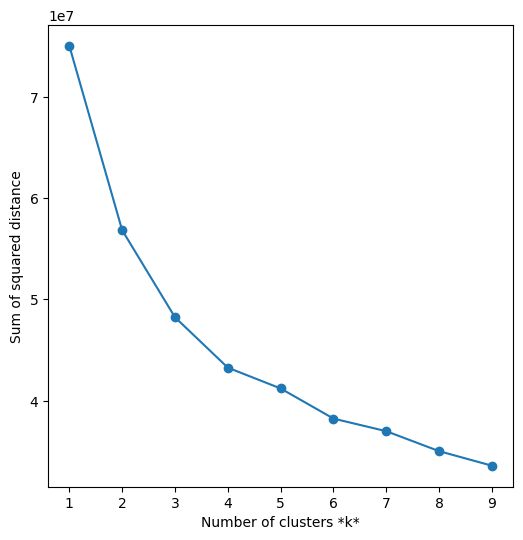

In [47]:
# Assuming X is your data
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()